# Examining Impact of Priors

#### Adapted from Doing Bayesian Data Analysis Ch 6

In [1]:
import scipy.stats as stats
import numpy as np
import scipy.special as sc
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import fmin

#### The goal of this notebook is to provide an example of how to do Bayesian inference analytically. Whilst not practical for serious applications this is good to show how we can begin with some prior allocation of credibility (prior), then we observe some data (likelihood) and from this we infer the posterior using Bayes' rule. 

#### For this example we take the case of a coin flip.

In [2]:
class BetaBernoulli:
    def __init__(self, prior_beta_ab, data, hdi_mass=0.95):
        if isinstance(prior_beta_ab, np.ndarray):
            pass
        elif isinstance(prior_beta_ab, list):
            prior_beta_ab = np.array(prior_beta_ab)
        else:
            raise TypeError("prior_beta_ab must be a numpy array or list")
            
        if np.any(prior_beta_ab < 0):
            raise ValueError("prior_beta_ab must be nonnegative")
        
        if len(prior_beta_ab) != 2:
            raise ValueError("prior_beta_ab must be a vector of two values")
        
        if isinstance(data, np.ndarray):
            pass
        elif isinstance(data, list):
            prior_beta_ab = np.array(prior_beta_ab)
        else:
            raise TypeError("data must be a numpy array or list")
            
        if not (np.any(data==1.) | np.any(data==0.)):
            raise ValueError("data must be 0 or 1")
        
        self.a = prior_beta_ab[0]
        self.b = prior_beta_ab[1]
        self.data = data
        self.hdi_mass = hdi_mass
        
    def generate_posterior(self, supress_output = False):
        self.z = sum(self.data)
        self.N = len(self.data)
        
        self.theta = np.arange(0.001, 1, 0.001)
        #prior
        self.p_theta = stats.beta.pdf(self.theta, self.a, self.b)
        #posterior
        self.p_theta_given_data = stats.beta.pdf(self.theta, self.a+self.z, self.b+self.N-self.z)
        #likelihood
        self.p_data_given_theta = self.theta**self.z*(1-self.theta)**(self.N-self.z)
        self.p_data = np.exp(np.log(sc.beta(self.a+self.z, self.b+self.N-self.z)) - np.log(sc.beta(self.a, self.b)))
        
        if not supress_output:
            return np.array([self.a+self.z, self.b+self.N-self.z])
        else:
            return
    
    def _get_prior_mode(self, a, b):
        return np.round((a-1)/(a+b-2), 3)

    def _get_posterior_mode(self, a, b, z, N):
        return np.round((a+z-1)/(a+b+N-2), 3)
    
    def _plot_util(self, y_val, axes, ax_idx, y_lab, title):
        axes[ax_idx].plot(self.theta, y_val)
        axes[ax_idx].set_ylabel(y_lab)
        axes[ax_idx].set_title(title)
        axes[ax_idx].fill_between(self.theta, y_val, 0,
                 facecolor="purple", 
                 color='blue',       
                 alpha=0.2)  
        
    def plot(self, show_hdi=True):
        #TODO: Refactor to take the repetition out
        self.generate_posterior(supress_output=True)
        
        fig, axes = plt.subplots(3, 1, figsize=(15,10))
        
        for ax in axes: 
            ax.set_xlabel(r"$\theta$")
        #plot prior
        self._plot_util(self.p_theta, axes, 0, "dbeta({0}| {1}, {2})".format(r"$\theta$ ", self.a, self.b), "Prior (beta)")
        mode = self._get_prior_mode(self.a,self.b)
        if mode == np.nan:
            pass
        else:
            axes[0].text(min(self.theta), max(self.p_theta)*0.9, f'mode={mode}', horizontalalignment="left", verticalalignment="top")
        
        if (self.a + self.b - 2 > 0):
            prior_hdi = IcdfHdi(stats.beta, a = self.a, b = self.b)
            prior_hdi_info = prior_hdi.get_low_tail_pr()
            prior_hdi_height = prior_hdi.get_hdi_height()
            axes[0].hlines(np.repeat(prior_hdi_height, len(prior_hdi_info)), xmin= prior_hdi_info[0], xmax=prior_hdi_info[1], colors='orange')
            axes[0].text(prior_hdi_info[0],prior_hdi_height, str(np.round(prior_hdi_info[0],3)))
            axes[0].text(prior_hdi_info[1],prior_hdi_height, str(np.round(prior_hdi_info[1],3)))
            axes[0].text(np.median(prior_hdi_info), (5*np.median(prior_hdi_info)), str(f"{self.hdi_mass*100}% HDI"), fontsize='large')
        
        
        #plot likelihood
        self._plot_util(self.p_data_given_theta, axes, 1, "P(D|{0})".format(r"$\theta$ "), "Likelihood (Bernoulli)")
        axes[1].text(min(self.theta), max(self.p_data_given_theta)*0.9, f'Data: z={self.z}, N={self.N}')
        mode_theta = self.theta[np.argmax(bb.p_data_given_theta)]
        axes[1].text(min(self.theta), max(self.p_data_given_theta)*0.8, f'max={mode_theta}')
        
        #plot posterior
        self._plot_util(self.p_theta_given_data, axes, 2, "dbeta({0}| {1}, {2})".format(r"$\theta$ ", self.a+self.z, self.b+self.N-self.z), 
                        "Posterior (Beta)")
        mode = self._get_posterior_mode(self.a,self.b, self.z, self.N)
        axes[2].text(min(self.theta), max(self.p_theta_given_data)*0.9, f'mode={mode}', horizontalalignment="left", verticalalignment="top")
            
        if (self.a + self.b + self.N - 2 > 0):
            prior_hdi = IcdfHdi(stats.beta, a=self.a+self.z, b=self.b+self.N-self.z)
            prior_hdi_info = prior_hdi.get_low_tail_pr()
            prior_hdi_height = prior_hdi.get_hdi_height()

            axes[2].hlines(np.repeat(prior_hdi_height, len(prior_hdi_info)), xmin= prior_hdi_info[0], xmax=prior_hdi_info[1], colors='orange')
            axes[2].text(prior_hdi_info[0],prior_hdi_height, str(np.round(prior_hdi_info[0],3)))
            axes[2].text(prior_hdi_info[1],prior_hdi_height, str(np.round(prior_hdi_info[1],3)))
            axes[2].text(np.median(prior_hdi_info), (5*np.median(prior_hdi_info)), str(f"{self.hdi_mass*100}% HDI"), fontsize='large')
        
        fig.tight_layout()
        

In [3]:
class IcdfHdi:
    '''Computes the highest density interval of a pdf'''
    
    def __init__(self, pdf, cred_mass=0.95, tolerance=1e-8, **pdf_kwargs):
        self.icd_fn = pdf(**pdf_kwargs)
        self.cred_mass = cred_mass
        self.tolerance = tolerance
        print(self.icd_fn)
    def _interval_width(self, low_tail_prob):
        return self.icd_fn.ppf(self.cred_mass + low_tail_prob) - self.icd_fn.ppf(low_tail_prob)
    
    def get_low_tail_pr(self):
        incred_mass = 1 - self.cred_mass
        opt_info = fmin(self._interval_width, incred_mass, ftol=self.tolerance, disp=False)[0]
        return self.icd_fn.ppf([opt_info, self.cred_mass+opt_info])
    
    def get_hdi_height(self):
        hdf_infp = self.icd_fn.pdf(self.get_low_tail_pr())
        return np.mean(hdf_infp)

In [4]:
def generate_data(t=0.75, n = 25):
    t = t
    n = n
    a = t*(n-2) + 1
    b = (1-t)*(n-2) + 1
    prior = np.array([a,b])
    N = 20
    z = 17
    data = np.hstack([np.zeros(N-z), np.ones(z)])
    print(f'a:{a} b: {b}')
    return prior, data


#### A weakly informative prior has a more limited impact on the posterior

In [5]:
prior, data = generate_data()

a:18.25 b: 6.75


In [6]:
bb = BetaBernoulli(prior_beta_ab=prior, data = data)

0.75


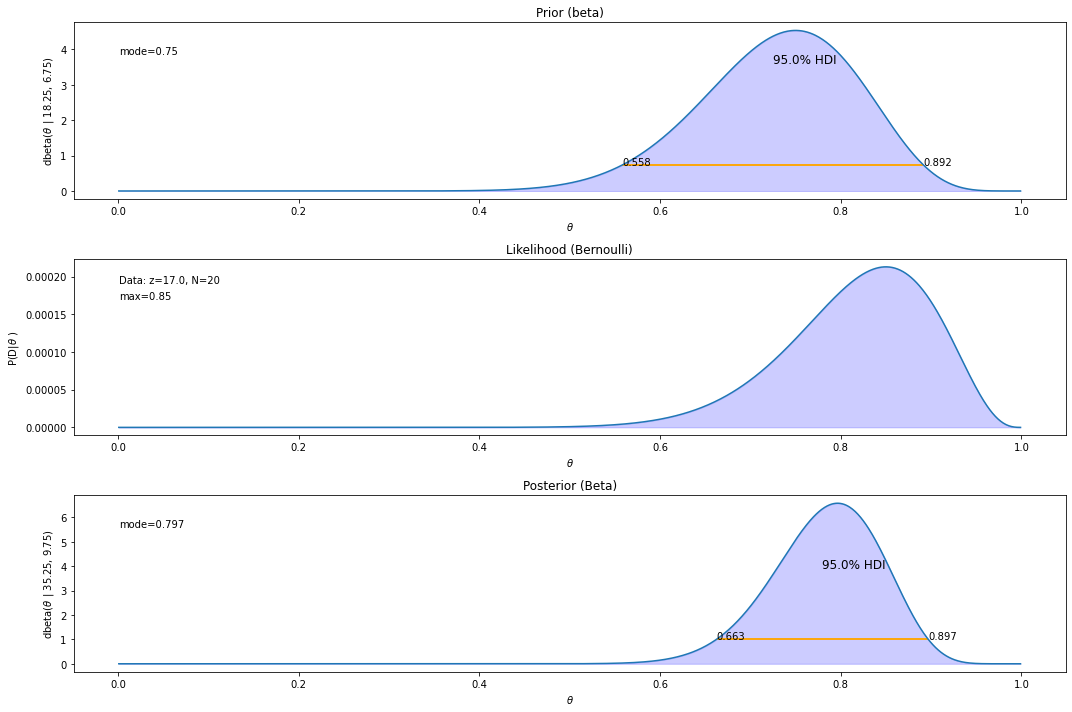

In [8]:
bb.plot()

In [9]:
prior, data = generate_data(0.5, 200)

a:100.0 b: 100.0


0.5


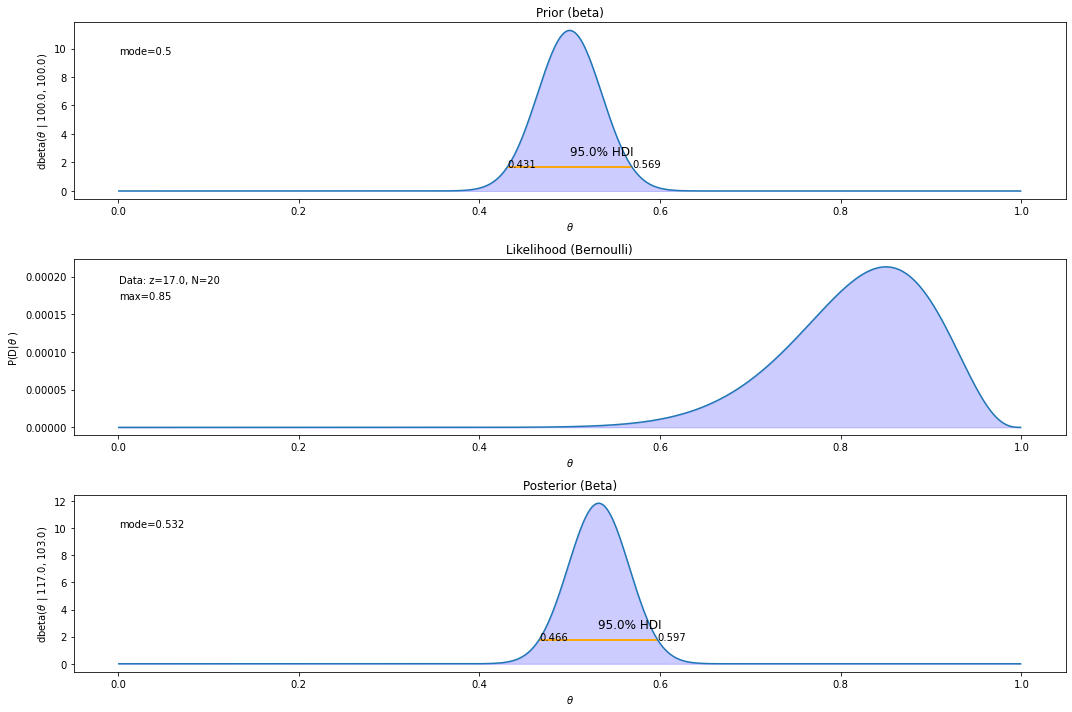

In [10]:
bb = BetaBernoulli(prior_beta_ab=prior, data = data)
bb.plot()

In [11]:
prior, data = generate_data(0.5, 2)

a:1.0 b: 1.0


nan


<ipython-input-2-b34b2700673b>:50: RuntimeWarning: invalid value encountered in double_scalars
  return np.round((a-1)/(a+b-2), 3)


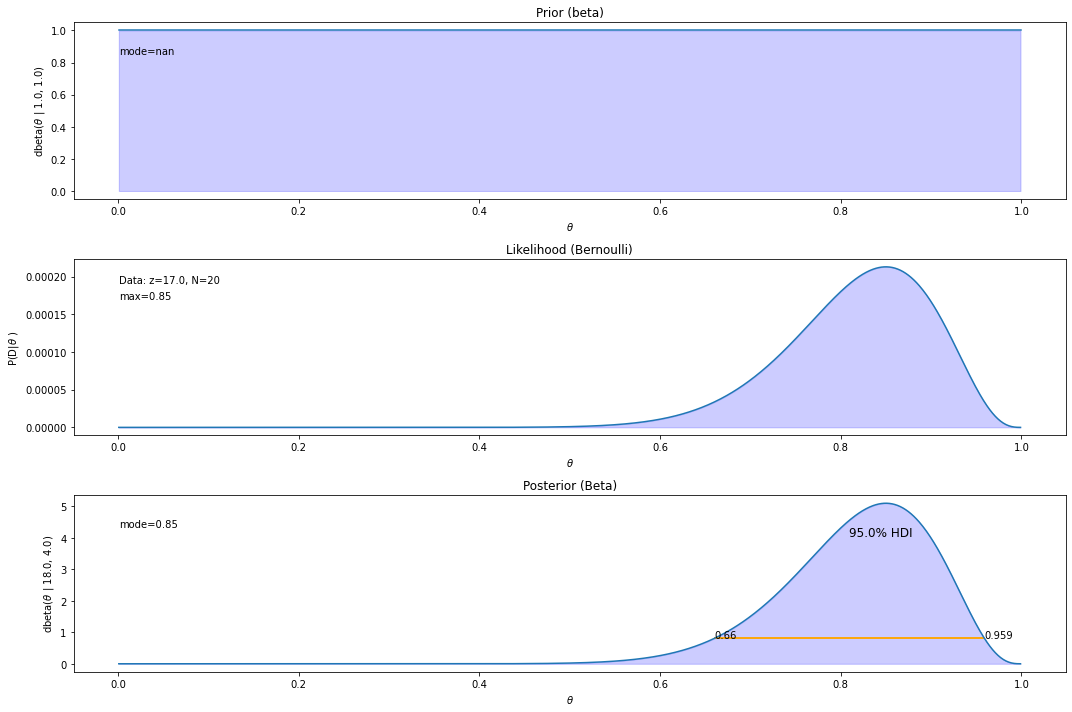

In [12]:
bb = BetaBernoulli(prior_beta_ab=prior, data = data)
bb.plot()